In [1]:
versioninfo()

Julia Version 1.10.4
Commit 48d4fd4843 (2024-06-04 10:41 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 24 × 12th Gen Intel(R) Core(TM) i9-12900K
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, alderlake)
Threads: 4 default, 0 interactive, 2 GC (on 24 virtual cores)
Environment:
  JULIA_NUM_THREADS = 4


In [2]:
using Pkg; Pkg.status()

Status `C:\Users\o6m1g\.julia\environments\v1.10\Project.toml`
  [99985d1d] AbstractGPs v0.5.21
⌃ [c75e803d] AdaptiveRejectionSampling v0.1.2
⌅ [0bf59076] AdvancedHMC v0.5.5
⌅ [5b7e9947] AdvancedMH v0.7.5
  [488c2830] BSplines v0.3.3
  [0a1fb500] BlockDiagonals v0.1.42
  [c88b6f0a] BridgeStan v2.5.0
⌃ [336ed68f] CSV v0.10.14
  [aaaa29a8] Clustering v0.15.7
  [8f4d0f93] Conda v1.10.2
⌃ [a93c6f00] DataFrames v1.6.1
  [055956cb] DiffEqPhysics v3.15.0
⌃ [0c46a032] DifferentialEquations v7.10.0
⌃ [31c24e10] Distributions v0.25.109
  [cc61a311] FLoops v0.2.2
⌃ [587475ba] Flux v0.14.16
  [38e38edf] GLM v1.9.0
  [bd48cda9] GraphRecipes v0.5.13
⌃ [34004b35] HypergeometricFunctions v0.3.23
⌃ [09f84164] HypothesisTests v0.11.0
⌃ [7073ff75] IJulia v1.25.0
  [4138dd39] JLD v0.13.5
  [682c06a0] JSON v0.21.4
⌃ [b964fa9f] LaTeXStrings v1.3.1
⌃ [6fdf6af0] LogDensityProblems v2.1.1
  [10e44e05] MATLAB v0.8.4
⌃ [c7f686f2] MCMCChains v5.7.1
⌃ [86f7a689] NamedArrays v0.10.2
⌃ [bac558e1] OrderedCollections 

# Packages

In [3]:
include("Init.jl")

In [4]:
using Turing

# Examples

## Radon

In [6]:
df = CSV.read("data/radon/radon.csv", DataFrame);

In [7]:
first(df, 4)

Row,log_radon,floor,log_u,county
,Float64,Int64,Float64,String31
1,1.43508,0,0.165862,MARTIN
2,1.02962,0,-0.418054,RAMSEY
3,0.262364,0,-0.418054,RAMSEY
4,1.28093,0,-0.418054,RAMSEY


In [8]:
struct Data_Radon
    y::Vector{Float64}
    X::Matrix{Float64}
    U::Matrix{Float64}
    county::Vector{Int64}
    N::Int64
    G::Int64
    N_g::Vector{Int64}
end

In [9]:
let
    X = [ones(size(df, 1)) df.floor]
    y = df.log_radon

    N = length(y)
    G = df.county |> unique |> length

    @assert length(unique(df.log_u)) == length(unique(df.county)) == 85
    #country_dict = 
    u = unique(df.log_u)
    U = [ones(85) u]

    county_dict = Dict(g => g_i for (g_i, (g, u_g)) in zip(unique(df.county), unique(df.log_u)) |> enumerate)
    county = [county_dict[g] for g in df.county]
    
    N_g = sum(df.county .== permutedims(unique(df.county)); dims=1) |> vec
    
    global data = Data_Radon(y, X, U, county, N, G, N_g)
end

Data_Radon([1.4350845252893225, 1.0296194171811583, 0.26236426446749106, 1.2809338454620642, 1.7227665977411035, 1.7227665977411035, 0.26236426446749106, 1.6094379124341003, 1.410986973710262, 1.2809338454620642  …  1.3350010667323402, -0.5108256237659907, 0.09531017980432493, 0.4054651081081644, -0.6931471805599453, -0.5108256237659907, 0.5306282510621705, 0.0, 2.2192034840549946, 0.8329091229351041], [1.0 0.0; 1.0 0.0; … ; 1.0 1.0; 1.0 1.0], [1.0 0.16586183575526953; 1.0 -0.418053510614464; … ; 1.0 -0.7518722327017873; 1.0 -0.6633476306014291], [1, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  56, 13, 51, 52, 13, 13, 13, 13, 15, 82], 919, 85, [7, 32, 5, 3, 3, 6, 4, 4, 2, 11  …  12, 6, 5, 4, 4, 3, 4, 5, 3, 11])

### Initial draw

In [10]:
@model function Model(
        data::Data_Radon,
        leave_g::Int64,
        ϕ::Union{Float64, Int64},
    )
    Γ ~ filldist(Normal(), 2, 2)
    v_β ~ filldist(Exponential(), 2)
    v_y ~ Exponential()
    
    β = Vector(undef, data.G)
    for g in 1:data.G
        β[g] ~ MvNormal(Γ * data.U[g,:], v_β |> Diagonal)
    end
    
    for i in 1:data.N
        _power = data.county[i] == leave_g ? (1 - ϕ) : 1
        Turing.@addlogprob! _power * logpdf(Normal(data.X[i,:]' * β[data.county[i]], v_y), data.y[i])
    end
    
    (; Γ, v_β, v_y, β)
end

Model (generic function with 2 methods)

In [10]:
let
    _model = Model(data, -1, 0)
    
    ℓπ = LogDensityFunction(_model)
    DynamicPPL.link!!(ℓπ.varinfo, _model)
    
    D = LogDensityProblems.dimension(ℓπ)
    metric = DiagEuclideanMetric(D)
    hamiltonian = Hamiltonian(metric, ℓπ)
    
    n_samples, n_burn, n_adapts = 1_000, 1_000, 1_000
    initial_θ = ones(D)
    initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
    integrator = Leapfrog(initial_ϵ)

    # Static HMC
    # kernel = HMCKernel(Trajectory{EndPointTS}(integrator, FixedNSteps(125)))
    # adaptor = NoAdaptation()

    #
    kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
    adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
    
    samples, stats = sample(hamiltonian, kernel, initial_θ, n_samples + n_burn, adaptor, n_adapts; progress=true)

    global chain = samples[n_burn+1:1:end] .|> inverse(bijector(_model))
end;

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\o6m1g\.julia\packages\ProgressMeter\kVZZH\src\ProgressMeter.jl:594
Sampling 100%|███████████████████████████████| Time: 0:06:56
  iterations:                                   2000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.02
  n_steps:                                      15
  is_accept:                                    true
  acceptance_rate:                              0.9682197285021872
  log_density:                                  -969.119280532602
  hamiltonian_energy:                           1061.4270246000137
  hamiltonian_energy_error:                     -0.5500917671806747


### Naive LGO

In [92]:
times_radon = Float64[]

for leave_g in 1:data.G
    @info "Leaving g=$(leave_g) out"
    _model = Model(data, leave_g, 1)

    ℓπ = LogDensityFunction(_model)
    DynamicPPL.link!!(ℓπ.varinfo, _model)
    
    D = LogDensityProblems.dimension(ℓπ)
    metric = DiagEuclideanMetric(D)
    hamiltonian = Hamiltonian(metric, ℓπ)
    
    n_samples, n_burn, n_adapts = 1_000, 1_000, 1_000
    initial_θ = ones(D)
    initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
    integrator = Leapfrog(initial_ϵ)
    
    # kernel = HMCKernel(Trajectory{EndPointTS}(integrator, FixedNSteps(125)))
    # adaptor = NoAdaptation()
    kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
    adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
    
    time = @elapsed samples, stats = sample(hamiltonian, kernel, initial_θ, n_samples + n_burn, adaptor, n_adapts; progress=true)
    push!(times_radon, time)
    save("output/radon/times_radon_mcmc.jld", "data", times_radon)
    
    chain = samples[n_burn+1:1:end] .|> inverse(bijector(_model))
    save("output/radon/chain_radon_lgo-$(leave_g).jld", "data", chain)
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\o6m1g\.julia\packages\ProgressMeter\kVZZH\src\ProgressMeter.jl:594
Sampling 100%|███████████████████████████████| Time: 0:08:06
  iterations:                                   2000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.01
  n_steps:                                      15
  is_accept:                                    true
  acceptance_rate:                              0.8388234945849857
  log_density:                                  -949.0833117966156
  hamiltonian_energy:                           1024.5242371990307
  hamiltonian_energy_error:                     0.2192100383840625


### SMC-LGO

In [33]:
# save("output/radon/chain_radon.jld", "data", chain)
chain = load("output/radon/chain_radon.jld")["data"];

In [15]:
function SMCS_Radon(chain::Vector{Vector{Float64}}, leave_g::Int64)
    model = Model(data, leave_g, 0)
    draws_0 = chain .|> bijector(model) |> vecvec2mat # unconstrain
    
    # Define problem dimensions
    R = size(draws_0, 1)
    D = size(draws_0, 2)
    L = data.N_g[leave_g] # maximum
    _names = sample(model, Prior(), 1).name_map.parameters .|> String
    
    # Obtain unconstrained prior draw
    Θ_0 = NamedArray(
        draws_0,
        (1:R, _names),
        (:n, :d),
    )
    
    # Initialize containers
    particles   = NamedArray(zeros(L+1, R, D), (0:L, 1:R, _names), (:l, :n, :d))
    # log_weights = NamedArray(zeros(L+1, R), (0:L, 1:R), (:l, :n))
    weights     = NamedArray(zeros(L+1, R), (0:L, 1:R), (:l, :n))
    k̂           = nothing # NamedArray(zeros(L+1), 0:L, :l)
    # mean_est  = NamedArray(zeros(L+1, D), (0:L, _names), (:l, :d))
    # ESS         = NamedArray(zeros(L+1), 0:L, :l)
    mcmc_flag   = NamedArray(zeros(L+1), 0:L, :l)
    ϕ_history   = NamedArray(zeros(L+1), 0:L, :l)
    
    # Log weights normalizer
    function _normalize(_log_w::Vector{Float64})::Vector{Float64}
        # normalize log weights
        _w = exp.(_log_w .- maximum(_log_w))
        _w = _w / sum(_w)
        _w
    end

    # ESS computer
    function _ess(_w::Vector{Float64})::Float64
        1 / sum(@. exp(2 * log(_w)))
        # No: 1 / sum(@. exp(2 * _log_w))
    end

    # Log ratio
    function log_G(ℓπ_0, ℓπ_1, l::Int, n::Int)::Float64
        _particle = particles[:l => l-1, :n => n]
        log_γ_0 = LogDensityProblems.logdensity(ℓπ_0, _particle)
        log_γ_1 = LogDensityProblems.logdensity(ℓπ_1, _particle)
        log_γ_1 - log_γ_0
    end

    # MCMC 
    function _move(initial_θ::Vector{Float64},
            n_samples::Int, n_adapts::Int,
            metric, hamiltonian, initial_ϵ)::Vector{Float64}
        #initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
        integrator = Leapfrog(initial_ϵ)
        #kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
        adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
        kernel = HMCKernel(Trajectory{EndPointTS}(integrator, FixedNSteps(15)))
        #adaptor = NoAdaptation()
        samples, stats = sample(hamiltonian, kernel, initial_θ, n_samples, adaptor, n_adapts;
            verbose=false, progress=false)
        samples[end]#, stats[end]
    end
    
    # Set initial values, starting index
    particles[:l => 0] = Θ_0 # sample from prior
    weights[:l => 0] = repeat([1/R], R)
    ϕ_history[:l => 0] = 0.
    
    time = @elapsed for l in 1:L
        # Inherit case-deleted model from previous iteration
        model_0 = Model(data, leave_g, ϕ_history[:l => l-1])
        ℓπ_0 = LogDensityFunction(model_0)
        DynamicPPL.link!!(ℓπ_0.varinfo, model_0)

        # Define (until ↦ ESS) map
        function _ϕ2reff(ϕ::Union{Float64, Int64})::Float64
            @assert 0 <= ϕ <= 1 # data.N_g[leave_g]
            model_1 = Model(data, leave_g, ϕ)
            ℓπ_1 = LogDensityFunction(model_1)
            DynamicPPL.link!!(ℓπ_1.varinfo, model_1)
            
            _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R]
            _log_weights = _log_weights .- maximum(_log_weights)
            
            _ESS = _log_weights |> _normalize |> _ess
            _ESS - 0.5R
        end
        
        # Initialize next distribution parameter
        ϕ_1 = nothing
        
        # Case 1: ESS is above threshold
        if _ϕ2reff(1) > 0
            # Define next as final distribution
            ϕ_1 = 1
            
            # Compute log weights
            model_1 = Model(data, leave_g, ϕ_1)
            ℓπ_1 = LogDensityFunction(model_1)
            DynamicPPL.link!!(ℓπ_1.varinfo, model_1)
            _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R]
            _log_weights = _log_weights .- maximum(_log_weights)

            # Adaptive
            _psis = psis(_log_weights; warn=false)

            # Case 1-1: PSIS
            if _psis.pareto_shape < 0.7
                mcmc_flag[:l => l] = false
                @info "ϕ=$(ϕ_1), PSIS"
                
                # (a) Without resampling
                particles[:l => l] = particles[:l => l-1]
                weights[:l => l] = _psis.log_weights |> _normalize

                # # (b) With resampling
                # A_0 = wsample(1:R, _log_weights |> _normalize, R)
                # particles[:l => l] = particles[:l => l-1, :n => A_0]
                # weights[:l => l] = repeat([1/R], R)
                
                k̂ = _psis.pareto_shape
                ϕ_history[:l => l] = ϕ_1
            
            # Case 1-2: MCMC kernel
            else
                mcmc_flag[:l => l] = true
                 @info "ϕ=$(ϕ_1), MCMC"
                
                # MCMC kernel
                A_0 = wsample(1:R, _log_weights |> _normalize, R)
                _begin = particles[:l => l-1, :n => A_0]
                _end = particles[:l => l, :n => 1:R] |> similar
                metric = DiagEuclideanMetric(D)
                hamiltonian = Hamiltonian(metric, ℓπ_1)
                initial_ϵ = find_good_stepsize(hamiltonian, _begin[1,:])
                
                # @showprogress for n in 1:R
                p = ProgressMeter.Progress(R); @Threads.threads for n in 1:R
                    _end[n,:] = _move(_begin[n,:], 1, 1, metric, hamiltonian, initial_ϵ)
                    ProgressMeter.next!(p)
                end
                
                particles[Name(l), :, :,] = _end
                weights[:l => l] = repeat([1/R], R)
                ϕ_history[:l => l] = ϕ_1
            end
            
            # Break loop
            L = l
            break

        # Case 2: ESS is below threshold
        else
            mcmc_flag[:l => l] = true
            
            # Find next distribution
            ϕ_1 = find_zero(_ϕ2reff, (ϕ_history[:l => l-1] + 1e-4, 1), xtol=0.1, maxiters=10, verbose=true)
            @info "Targeting ϕ=$(ϕ_1)"
            
            # Compute log weights
            model_1 = Model(data, leave_g, ϕ_1)
            ℓπ_1 = LogDensityFunction(model_1)
            DynamicPPL.link!!(ℓπ_1.varinfo, model_1)
            _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R]
            _log_weights = _log_weights .- maximum(_log_weights)

            # MCMC kernel
            A_0 = wsample(1:R, _log_weights |> _normalize, R)
            _begin = particles[:l => l-1, :n => A_0]
            _end = particles[:l => l, :n => 1:R] |> similar
            metric = DiagEuclideanMetric(D)
            hamiltonian = Hamiltonian(metric, ℓπ_1)
            initial_ϵ = find_good_stepsize(hamiltonian, _begin[1,:])
            
            # @showprogress for n in 1:R
            p = ProgressMeter.Progress(R); @Threads.threads for n in 1:R
                _end[n,:] = _move(_begin[n,:], 3, 1, metric, hamiltonian, initial_ϵ)
                ProgressMeter.next!(p)
            end
            
            particles[Name(l), :, :,] = _end
            weights[:l => l] = repeat([1/R], R)
            ϕ_history[:l => l] = ϕ_1
        end
    end

    particles = particles[Name(L),:,:]
    weights   = weights[Name(L), :]
    mcmc_flag = mcmc_flag[Name(L)]
    ϕ_history = ϕ_history[Name.(0:L)]

    (; R, D, L, particles, weights, ϕ_history, k̂, mcmc_flag, time)
end

SMCS_Radon (generic function with 1 method)

In [20]:
function Compute_LPDs(results, leave_g::Int64; constrain=true)::Vector{Float64}
    
    _model = Model(data, -1, 0)
    _names = sample(_model, Prior(), 1).name_map.parameters .|> String
    
    function LPD(particle)::Float64
        particle = NamedArray(
            constrain ? particle |> inverse(bijector(_model)) : particle,
            _names,
            :d
        )
        β = particle[:d => ["β[$(leave_g)][$(k)]" for k in 1:2]]
        v_y = particle[:d => "v_y"]
        logpdf(MvNormal(X_g * β, v_y * I), y_g)
    end
    
    leave_g_idx = data.county .== leave_g
    y_g, X_g = data.y[leave_g_idx], data.X[leave_g_idx,:]
    @assert data.N_g[leave_g] == sum(leave_g_idx)

    LPDs = Float64[]
    @showprogress for n in 1:results.R
        push!(LPDs, results[:particles][:n => n] |> LPD)
    end
    
    LPDs
end

Compute_LPDs (generic function with 1 method)

In [ ]:
let
    Random.seed!(1)
    use_chain = chain

    R = length(use_chain)
    global particles = []
    global weights = []
    global ϕ_histories = []
    global k̂s = []
    global times = Float64[]
    for leave_g in 1:data.G
        @info "Leaving g=$(leave_g) out"
        results = SMCS_Radon(use_chain, leave_g)
        #break
        push!(particles, results[:particles])
        push!(weights, results[:weights])
        push!(ϕ_histories, results[:ϕ_history])
        push!(k̂s, results[:k̂])
        push!(times, results[:time])
    end
    
    global particles_radon = particles
    global weights_radon = weights
    global histories_radon = ϕ_histories
    global k̂s_radon = k̂s
    global times_radon = times
end;

In [44]:
save("output/radon/particles_radon.jld", "data", particles_radon .|> Matrix) # [g][n,d]
save("output/radon/weights_radon.jld", "data", weights_radon .|> Vector) # [g][n]
save("output/radon/histories_radon.jld", "data", histories_radon .|> Vector) # [g][L_g]
save("output/radon/khats_radon.jld", "data", k̂s_radon) # g
save("output/radon/times_radon.jld", "data", times_radon) # g

### PSIS-LGO

In [179]:
function PSIS_Radon(chain::Vector{Vector{Float64}}, leave_g::Int64)
    model = Model(data, leave_g, 0)
    draws_0 = chain .|> bijector(model) |> vecvec2mat # unconstrain
    
    # Define problem dimensions
    R = size(draws_0, 1)
    D = size(draws_0, 2)
    L = 1 # maximum
    _names = sample(model, Prior(), 1).name_map.parameters .|> String
    
    # Obtain unconstrained prior draw
    Θ_0 = NamedArray(
        draws_0,
        (1:R, _names),
        (:n, :d),
    )
    
    # Initialize containers
    particles   = NamedArray(zeros(L+1, R, D), (0:L, 1:R, _names), (:l, :n, :d))
    weights     = NamedArray(zeros(L+1, R), (0:L, 1:R), (:l, :n))
    k̂           = nothing
    mcmc_flag   = NamedArray(zeros(L+1), 0:L, :l)
    
    # Log weights normalizer
    function _normalize(_log_w::Vector{Float64})::Vector{Float64}
        # normalize log weights
        _w = exp.(_log_w .- maximum(_log_w))
        _w = _w / sum(_w)
        _w
    end

    # Log ratio
    function log_G(ℓπ_0, ℓπ_1, l::Int, n::Int)::Float64
        _particle = particles[:l => l-1, :n => n]
        log_γ_0 = LogDensityProblems.logdensity(ℓπ_0, _particle)
        log_γ_1 = LogDensityProblems.logdensity(ℓπ_1, _particle)
        log_γ_1 - log_γ_0
    end
    
    # Set initial values, starting index
    particles[:l => 0] = Θ_0 # sample from prior
    weights[:l => 0] = repeat([1/R], R)
    
    time = @elapsed (l = 1;
        ϕ_0 = 0;
        model_0 = Model(data, leave_g, ϕ_0);
        ℓπ_0 = LogDensityFunction(model_0);
        DynamicPPL.link!!(ℓπ_0.varinfo, model_0);
        
        # Compute log weights
        ϕ_1 = 1;
        model_1 = Model(data, leave_g, ϕ_1);
        ℓπ_1 = LogDensityFunction(model_1);
        DynamicPPL.link!!(ℓπ_1.varinfo, model_1);
        
        _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R];
        _log_weights = _log_weights .- maximum(_log_weights);

        # PSIS
        _psis = psis(_log_weights; warn=false);
        particles[:l => l] = particles[:l => l-1];
        weights[:l => l] = _psis.log_weights |> _normalize;
    )
    
    k̂ = _psis.pareto_shape;
    particles = particles[Name(L),:,:]
    weights   = weights[Name(L), :]

    (; R, D, L, particles, weights, k̂, time)
end

PSIS_Radon (generic function with 1 method)

In [14]:
let
    Random.seed!(1)
    use_chain = chain

    R = length(use_chain)
    particles = []
    weights = []
    k̂s = []
    times = Float64[]
    for leave_g in 1:data.G
        @info "Leaving g=$(leave_g) out"
        results = PSIS_Radon(use_chain, leave_g)
        
        push!(particles, results[:particles])
        push!(weights, results[:weights])
        push!(k̂s, results[:k̂])
        push!(times, results[:time])
    end
    
    global particles_radon = particles
    global weights_radon = weights
    global k̂s_radon = k̂s
    global times_radon = times
end;

[ Info: Leaving g=1 out
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
[ Info: Leaving g=2 out
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
[ Info: Leaving g=3 out
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
[ Info: Leaving g=4 out
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
[ Info: Leaving g=5 out
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
[ Info: Leaving g=6 out
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
[ Info: Leaving g=7 out
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
[ Info: Leaving g=8 out
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
[ Info: Leaving g=9 out
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
[ Info: Leaving g=10 out
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
[ Info: Leaving g=11 out
Progress: 100%

In [15]:
save("output/radon/psis/particles_radon.jld", "data", particles_radon .|> Matrix) # [g][n,d]
save("output/radon/psis/weights_radon.jld", "data", weights_radon .|> Vector) # [g][n]
save("output/radon/psis/khats_radon.jld", "data", k̂s_radon) # g
save("output/radon/psis/times_radon.jld", "data", times_radon) # g

### Figures

#### LPD

In [21]:
let
    LPD = NamedArray(
        zeros(R, data.G),
        (1:R, 1:data.G),
        (:n, :g)
    )
    global LPD_true = LPD_estimate |> similar
    global LPD_estimate = LPD |> similar
    global LPD_estimate_psis = LPD |> similar
    global weights = load("output/radon/weights_radon.jld")["data"]
    global weights_psis = load("output/radon/psis/weights_radon.jld")["data"]
    
    for (g, leave_g) in enumerate(1:data.G)
        @info leave_g
        chain = load("output/radon/chain_radon_lgo-$(leave_g).jld")["data"]
        R = length(chain)
        LPD_true[:,g] = Compute_LPDs(
            (; particles=NamedArray(chain, 1:R, :n), R=R),
            leave_g;
            constrain=false
        )
    
        chain = load("output/radon/particles_radon.jld")["data"][g] |> mat2vecvec
        R = length(chain)
        LPD_estimate[:,g] = Compute_LPDs(
            (; particles=NamedArray(chain, 1:R, :n), R=R),
            leave_g;
            constrain=true
        )
    
        chain = load("output/radon/psis/particles_radon.jld")["data"][g] |> mat2vecvec
        R = length(chain)
        LPD_estimate_psis[:,g] = Compute_LPDs(
            (; particles=NamedArray(chain, 1:R, :n), R=R),
            leave_g;
            constrain=true
        )
    end
end

[ Info: 1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
[ Info: 2
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
[ Info: 3
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
[ Info: 4
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
[ Info: 5
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
[ Info: 6
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
[ In

In [ ]:
let
    _reorder_idx = _mean(LPD_true; dims=1) |> sortperm
    _reorder_idx = sortperm([sum(df.county .== g) for g in unique(df.county)], rev=true)
    _names = unique(df.county)[_reorder_idx]
    _countmap = df.county |> countmap
    
    _LPD_true = LPD_true[:, _reorder_idx]
    _LPD_estimate = LPD_estimate[:, _reorder_idx]
    _weights = weights[_reorder_idx]
    _LPD_estimate_psis = LPD_estimate_psis[:, _reorder_idx]
    _weights_psis = weights_psis[_reorder_idx]
    
    R, G = size(_LPD_true, 1), size(_LPD_true, 2)
    _equal_weights_cumsum = repeat([1/R], R) |> cumsum

    n_rows = 2
    plts = []
    #for g in 1:6#[1,2,6,9,10]#LinRange(2, 0.3G, 3n_rows) .|> round .|> Int
    for g in LinRange(1, 0.7G, 3n_rows) .|> round .|> Int
        plot(_LPD_true[:,g] |> sort, _equal_weights_cumsum,
            color=:blue, label=" MCMC", linewidth=2)
        _idx = _LPD_estimate[:,g] |> sortperm
        plot!(_LPD_estimate[_idx, g], _weights[g][_idx] |> cumsum,
            color=:red, label=" SMC", linewidth=3, linestyle=:dot, alpha=0.7)
        _idx = _LPD_estimate_psis[:,g] |> sortperm
        plot!(_LPD_estimate_psis[_idx, g], _weights_psis[g][_idx] |> cumsum,
            color=:green, label=" PSIS", linewidth=3, linestyle=:dot, alpha=0.7)
        push!(plts, plot!(title="$(_names[g]) (" * L"N_g" * "=$(_countmap[_names[g]]))", legend=g == 1 ? true : false, xlim=(_LPD_estimate[:,g] |> minimum, _LPD_true[:,g] |> maximum)))
    end
    plot(plts..., layout=(n_rows, 3), size=(700,125n_rows), titlefontsize=9, tickfontsize=6, xrot=-90, bottommargin=3Plots.mm)
    savefig("img/radon-lpd-compare-approx.pdf")
end

In [ ]:
let
    _counts = [sum(df.county .== g) for g in unique(df.county)]
    _reorder_idx = sortperm(_counts, rev=true)
    # _reorder_idx = sortperm(_mean(LPD_true; dims=1))#[1:10]
    _names = unique(df.county)[_reorder_idx]
    _counts = _counts[_reorder_idx]
    
    _true = _mean(LPD_true; dims=1)[_reorder_idx]
    _est_smc = _sum(vecvec2mat(weights)' .* LPD_estimate; dims=1)[_reorder_idx]
    _est_psis = _sum(vecvec2mat(weights_psis)' .* LPD_estimate_psis; dims=1)[_reorder_idx]

    _loss_smc = abs2.(_true - _est_smc) .|> sqrt
    _loss_psis = abs2.(_true - _est_psis) .|> sqrt
    plot(_counts, _loss_psis, color=:green, ms=3, mswidth=0, label="PSIS-LGO", alpha=0.7, markershape=:square, linestyle=:solid)
    plot!(_counts, _loss_smc, color=:red, ms=3, mswidth=0, label="SMC-LGO", alpha=1, markershape=:o, linestyle=:solid)

    for i in 1:6
        if i >= 5
            annotate!(_counts[i], _loss_smc[i] - 0.13, text(_names[i], 6, :top))
        else
            annotate!(_counts[i], _loss_psis[i] + 0.29, text(_names[i], 6))
        end
    end
    plot!(xlabel="Within-group observations " * L"N_g", ylabel="RMSE", ylim=(-0.6, 1.1maximum(_loss_psis)), bottommargin=2Plots.mm)
    savefig("img/radon-lpd-compare-rmse.pdf")
end

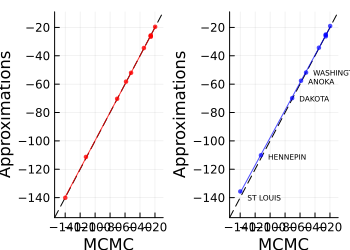

In [76]:
let
    _reorder_idx = sortperm(_mean(LPD_true; dims=1))[1:10]
    _names = unique(df.county)[_reorder_idx]
    
    _true = _mean(LPD_true; dims=1)[_reorder_idx]
    _est_smc = _sum(vecvec2mat(weights)' .* LPD_estimate; dims=1)[_reorder_idx]
    _est_psis = _sum(vecvec2mat(weights_psis)' .* LPD_estimate_psis; dims=1)[_reorder_idx]
    
    _min, _max = minimum([_true; _est_smc; _est_psis]), maximum([_true; _est_smc; _est_psis])
    plot([_min - 100, _max + 100], [_min - 100, _max + 100],
        label="", color=:black, linestyle=:dash)
    
    scatter!(_true, _est_smc, ms=2.5, mswidth=0, label="SMC", color=:red, alpha=0.8, smooth=true)
    #scatter!(_true, _est_psis, ms=2.5, mswidth=0, label="PSIS", color=:blue, alpha=0.7, smooth=false)
    plt_1 = plot!(size=(350,250), ylabel="Approximations", xlabel="MCMC",
        leftmargin=-2Plots.mm, bottommargin=-2Plots.mm,
        xlim=(1.1_min, _max + 10), ylim=(1.1_min, _max + 10), legend=false)
    
    plot([_min - 100, _max + 100], [_min - 100, _max + 100],
        label="", color=:black, linestyle=:dash)

    for i in 1:5
        annotate!(_true[i], _est_smc[i], text("   $(_names[i])", :left, 5))
    end
    
    # scatter!(_true, _est_smc, ms=2.5, mswidth=0, label="SMC", color=:red, alpha=0.8, smooth=false)
    scatter!(_true, _est_psis, ms=2.5, mswidth=0, label="PSIS", color=:blue, alpha=0.7, smooth=true)
    plt_2 = plot!(size=(350,250), ylabel="Approximations", xlabel="MCMC",
        leftmargin=-2Plots.mm, bottommargin=-2Plots.mm,
        xlim=(1.1_min, _max + 10), ylim=(1.1_min, _max + 10), legend=false)

    plot(plt_1, plt_2)
    #@info _true |> sum, _est_smc |> sum, _est_psis |> sum
    #savefig("img/radon-lpd-compare.pdf")
end

#### Runtime

In [12]:
let
    # _reorder_idx = sortperm(_mean(LPD_true; dims=1))
    _reorder_idx = sortperm([sum(df.county .== g) for g in unique(df.county)], rev=false)
    _names = unique(df.county)[_reorder_idx]
    _countmap = df.county |> countmap
    
    time_mcmc = load("output/radon/times_radon_mcmc.jld")["data"][_reorder_idx]/60
    time_smc = load("output/radon/times_radon.jld")["data"][_reorder_idx]/60
    time_psis = load("output/radon/psis/times_radon.jld")["data"][_reorder_idx]/60
    
    plot([time_mcmc time_smc time_psis],
        xticks=(1:data.G, _names), xrot=-90, xtickfontsize=5,
        xlabel="County", ylabel="Runtime [min.]",
        bottommargin=13Plots.mm, leftmargin=3Plots.mm, rightmargin=15Plots.mm,
        label=["MCMC-LGO " "SMC-LGO" "PSIS-LGO"], legendcolumns=-1, legend=false, size=(750, 300)
    )
    hspan!([mean(time_mcmc) - 2std(time_mcmc), mean(time_mcmc) + 2std(time_mcmc)], alpha=0.2, color=:blue)
    annotate!(data.G + 1, time_mcmc[end], text("MCMC-LGO", :blue, :left, 9))
    annotate!(data.G + 1, time_smc[end] + 0.5, text("SMC-LGO", :red, :left, 9))
    annotate!(data.G + 1, time_psis[end], text("PSIS-LGO", :green, :left, 9))

    histories = load("output/radon/histories_radon.jld")["data"]
    for (g, history) in enumerate(histories[_reorder_idx])
        L_g = length(history) - 1
        if L_g == 1
            annotate!(g, time_smc[g] - 0.1, text(L_g, :red, :top, 5))
        else
            annotate!(g, time_smc[g] + 0.1, text(L_g, :red, :bottom, 5))
        end
    end
    plot!(ylim=(-1.5, maximum([time_mcmc; time_smc; time_psis])))
    savefig("img/radon-runtime.pdf")
end;

#### Distributions

In [ ]:
let
    _reorder_idx = sortperm(data.N_g, rev=true)
    _idx = 1:5:data.G
    _names = unique(df.county)[_reorder_idx][_idx]
    _counts = data.N_g[_reorder_idx][_idx]
    histories = load("output/radon/histories_radon.jld")["data"][_reorder_idx][_idx]

    plot()#vline([0, 1], color=:red, label="")
    for (g, history) in enumerate(histories)
        for ℓ in history
            if 0 < ℓ < 1
                annotate!(ℓ, g + 0.2, text(round(ℓ; digits=2), :black, :bottom, 6))
            end
        end
        scatter!(history, repeat([g], length(history)), ms=3, mswidth=0.1, color=:red, label="")
    end
    plot!(
        xlim=(0-0.08, 1+0.08),
        xticks=(
            [0, 0.5, 1],
            [L"\varphi = 0" * "\n(Baseline)", L"\varphi = \frac{1}{2}", L"\varphi = 1" * "\n(Leave-group-out)"]
        ),
        yticks=(1:length(_idx), ["$(_names[i]) ($(_counts[i]))" for i in 1:length(_idx)]),
        ytickfontsize=7, size=(500,250),
        bottommargin=3Plots.mm, ymirror=true, rightmargin=5Plots.mm, topmargin=-1Plots.mm, leftmargin=1Plots.mm,
        xlabel="Adaptively determined paths"
    )
    savefig("img/radon-paths.pdf")
end

## M5

### Data

In [104]:
sales_train = CSV.read("data/m5-forecasting-accuracy/sales_train_validation.csv", DataFrame)
# sales_valid = CSV.read("data/m5-forecasting-accuracy/sales_train_evaluation.csv", DataFrame)
price = CSV.read("data/m5-forecasting-accuracy/sell_prices.csv", DataFrame)
calendar = CSV.read("data/m5-forecasting-accuracy/calendar.csv", DataFrame)
;

In [105]:
filter!(
    row -> (
        mask = true;
        # mask = mask & (row.state_id == "TX");
        # mask = mask & (row.dept_id == "HOBBIES_2");
        # mask = mask & (row.dept_id == "FOODS_1");
        # mask = mask & (row.cat_id == "FOODS");
    ),
    sales_train
);

In [106]:
struct Data_M5
    y::Any
    K_axis::Vector{String} # item_id
    S_axis::Vector{String} # space
    G_axis::Matrix{Float64} # cat_id, one-hot indicator matrix
    K::Int64
    S::Int64
    G::Int64 # # of unique cat_id
    valid_idx::Vector{Vector{String}} # vector of item_ids
end

In [108]:
let
    Random.seed!(1)
    
    # Define axis
    K_axis = [item_id for item_id in unique(sales_train.item_id) if 1 <= parse(Int64, split(item_id, "_")[end]) <= 30]
    S_axis = sales_train.store_id |> unique
    axes = (K_axis, S_axis)

    # Initialize missing complete panel
    y = NamedArray(
        Array{Union{Missing, Float64}, 2}(missing, length.(axes)...),
        axes,
        (:k, :s),
    )

    # Fill panel
    for k=K_axis, s=S_axis
        mask = (sales_train.item_id .=== k) .& (sales_train.store_id .=== s)
        @assert sum(mask) == 1
        _data = sales_train[mask, ["d_$(t)" for t in 1:1913]] |> Matrix |> vec
        y[Name(k), Name(s)] = _data |> diff |> mean
    end
    
    y = NamedArray(
        (Matrix(y) .- mean(y)) / std(y),
        axes,
        (:k, :s),
    )

    # Generate validation index
    G_axis = K_axis .|> (k -> k[1:end-4])
    K = 10
    valid_idx = repeat([String[]], K)
    
    for g in unique(G_axis)
        partition_g = Iterators.partition(K_axis[G_axis .== g] |> shuffle, 3) |> collect
        @assert length(partition_g) == K
        for fold_i in 1:K
            valid_idx[fold_i] = [valid_idx[fold_i]; partition_g[fold_i]]
        end
    end
    
    K = K_axis |> unique |> length
    S = S_axis |> unique |> length
    G = G_axis |> unique |> length

    _map = Dict(g => i for (i, g) in enumerate(unique(G_axis)))
    G_axis = [_map[g] for g in G_axis]
    G_axis = indicatormat(G_axis)'
    
    global data = Data_M5(y, K_axis, S_axis, G_axis, K, S, G, valid_idx)
    @info data.y |> size
end

[ Info: (209, 10)


### Initial draw

In [110]:
@model function Model(
        data::Data_M5,
        leave_g::Vector{String},
        ϕ::Union{Float64, Int64},
    )
    
    L ~ filldist(Normal(), data.S, data.S)
    L = L .* [i >= j for i=1:data.S, j=1:data.S]
    α_s ~ MvNormal(I(data.S))
    α_g ~ MvNormal(I(data.G))
    X_g = data.G_axis * α_g
    
    for (k_i, k) in enumerate(data.K_axis)
        _power = k ∈ leave_g ? (1 - ϕ) : 1
        μ = α_s .+ X_g[k_i]
        log_ℓ = _power * logpdf(MvNormal(I(data.S)), L \ (data.y[:k => k] - μ))
        Turing.@addlogprob! log_ℓ
    end
end

Model (generic function with 2 methods)

In [111]:
let
    _model = Model(data, ["none"], 0)
    
    ℓπ = LogDensityFunction(_model)
    DynamicPPL.link!!(ℓπ.varinfo, _model)
    
    D = LogDensityProblems.dimension(ℓπ)
    metric = DiagEuclideanMetric(D)
    hamiltonian = Hamiltonian(metric, ℓπ)
    
    n_samples, n_burn, n_adapts = 1_000, 1_000, 1_000
    initial_θ = ones(D)
    initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
    integrator = Leapfrog(initial_ϵ)
    
    # kernel = HMCKernel(Trajectory{EndPointTS}(integrator, FixedNSteps(100)))
    # adaptor = NoAdaptation()
    kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
    adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
    
    samples, stats = sample(hamiltonian, kernel, initial_θ, n_samples + n_burn, adaptor, n_adapts; progress=true)

    global chain = samples[n_burn+1:1:end] .|> inverse(bijector(_model))
end;

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\o6m1g\.julia\packages\ProgressMeter\kVZZH\src\ProgressMeter.jl:594
Sampling 100%|███████████████████████████████| Time: 0:10:25
  iterations:                                   2000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.01
  n_steps:                                      15
  is_accept:                                    true
  acceptance_rate:                              0.9838965463548828
  log_density:                                  -2222.1859915621462
  hamiltonian_energy:                           2277.9372891586877
  hamiltonian_energy_error:                     -0.318419004397128

In [112]:
save("output/M5/chain.jld", "data", chain)

### Naive LGO

In [113]:
times_M5 = Float64[]

for (fold_i, leave_g) in data.valid_idx |> enumerate
    @info "Fold $(fold_i)"
    
    _model = Model(data, leave_g, 1)
    
    ℓπ = LogDensityFunction(_model)
    DynamicPPL.link!!(ℓπ.varinfo, _model)
    
    D = LogDensityProblems.dimension(ℓπ)
    metric = DiagEuclideanMetric(D)
    hamiltonian = Hamiltonian(metric, ℓπ)
    
    n_samples, n_burn, n_adapts = 1_000, 1_000, 1_000
    initial_θ = ones(D)
    initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
    integrator = Leapfrog(initial_ϵ)
    
    # kernel = HMCKernel(Trajectory{EndPointTS}(integrator, FixedNSteps(100)))
    # adaptor = NoAdaptation()
    kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
    adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
    
    time = @elapsed samples, stats = sample(hamiltonian, kernel, initial_θ, n_samples + n_burn, adaptor, n_adapts; progress=true)
    push!(times_M5, time)
    save("output/M5/times-mcmc.jld", "data", times_M5)
    
    chain = samples[n_burn+1:1:end] .|> inverse(bijector(_model))
    save("output/M5/chain_lgo-$(fold_i).jld", "data", chain)
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\o6m1g\.julia\packages\ProgressMeter\kVZZH\src\ProgressMeter.jl:594
Sampling 100%|███████████████████████████████| Time: 0:10:37
  iterations:                                   2000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.0
  n_steps:                                      15
  is_accept:                                    true
  acceptance_rate:                              0.706696136254084
  log_density:                                  -2028.7134970948885
  hamiltonian_energy:                           2077.310093961844
  hamiltonian_energy_error:                     0.38568482701339235
 

### SMC-LGO

In [445]:
chain = load("output/M5/chain.jld")["data"];

In [446]:
function SMCS_M5(chain::Vector{Vector{Float64}}, leave_g::Vector{String})
    model = Model(data, leave_g, 0)
    draws_0 = chain .|> bijector(model) |> vecvec2mat # unconstrain
    
    # Define problem dimensions
    R = size(draws_0, 1)
    D = size(draws_0, 2)
    L = length(data.K_axis) # maximum
    _names = sample(model, Prior(), 1).name_map.parameters .|> String
    
    # Obtain unconstrained prior draw
    Θ_0 = NamedArray(
        draws_0,
        (1:R, _names),
        (:n, :d),
    )
    
    # Initialize containers
    particles   = NamedArray(zeros(L+1, R, D), (0:L, 1:R, _names), (:l, :n, :d))
    # log_weights = NamedArray(zeros(L+1, R), (0:L, 1:R), (:l, :n))
    weights     = NamedArray(zeros(L+1, R), (0:L, 1:R), (:l, :n))
    k̂           = nothing # NamedArray(zeros(L+1), 0:L, :l)
    # mean_est  = NamedArray(zeros(L+1, D), (0:L, _names), (:l, :d))
    # ESS         = NamedArray(zeros(L+1), 0:L, :l)
    mcmc_flag   = NamedArray(zeros(L+1), 0:L, :l)
    ϕ_history   = NamedArray(zeros(L+1), 0:L, :l)
    
    # Log weights normalizer
    function _normalize(_log_w::Vector{Float64})::Vector{Float64}
        # normalize log weights
        _w = exp.(_log_w .- maximum(_log_w))
        _w = _w / sum(_w)
        _w
    end

    # ESS computer
    function _ess(_w::Vector{Float64})::Float64
        1 / sum(@. exp(2 * log(_w)))
        # No: 1 / sum(@. exp(2 * _log_w))
    end

    # Log ratio
    function log_G(ℓπ_0, ℓπ_1, l::Int, n::Int)::Float64
        _particle = particles[:l => l-1, :n => n]
        log_γ_0 = LogDensityProblems.logdensity(ℓπ_0, _particle)
        log_γ_1 = LogDensityProblems.logdensity(ℓπ_1, _particle)
        log_γ_1 - log_γ_0
    end

    # MCMC 
    function _move(initial_θ::Vector{Float64},
            n_samples::Int, n_adapts::Int,
            metric, hamiltonian, initial_ϵ)::Vector{Float64}
        #initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
        integrator = Leapfrog(initial_ϵ)
        #kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
        adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
        kernel = HMCKernel(Trajectory{EndPointTS}(integrator, FixedNSteps(15)))
        #adaptor = NoAdaptation()
        samples, stats = sample(hamiltonian, kernel, initial_θ, n_samples, adaptor, n_adapts;
            verbose=false, progress=false)
        samples[end]#, stats[end]
    end
    
    # Set initial values, starting index
    particles[:l => 0] = Θ_0 # sample from prior
    weights[:l => 0] = repeat([1/R], R)
    ϕ_history[:l => 0] = 0.
    
    time = @elapsed for l in 1:L
        # Inherit case-deleted model from previous iteration
        model_0 = Model(data, leave_g, ϕ_history[:l => l-1])
        ℓπ_0 = LogDensityFunction(model_0)
        DynamicPPL.link!!(ℓπ_0.varinfo, model_0)

        # Define (until ↦ ESS) map
        function _ϕ2reff(ϕ::Union{Float64, Int64})::Float64
            @assert 0 <= ϕ <= 1 # data.N_g[leave_g]
            model_1 = Model(data, leave_g, ϕ)
            ℓπ_1 = LogDensityFunction(model_1)
            DynamicPPL.link!!(ℓπ_1.varinfo, model_1)
            
            _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R]
            _log_weights = _log_weights .- maximum(_log_weights)
            
            _ESS = _log_weights |> _normalize |> _ess
            _ESS - 0.25R
        end
        
        # Initialize next distribution parameter
        ϕ_1 = nothing
        
        # Case 1: ESS is above threshold
        if _ϕ2reff(1) > 0
            # Define next as final distribution
            ϕ_1 = 1
            
            # Compute log weights
            model_1 = Model(data, leave_g, ϕ_1)
            ℓπ_1 = LogDensityFunction(model_1)
            DynamicPPL.link!!(ℓπ_1.varinfo, model_1)
            _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R]
            _log_weights = _log_weights .- maximum(_log_weights)

            # Adaptive
            _psis = psis(_log_weights; warn=false)

            # Case 1-1: PSIS
            if false#_psis.pareto_shape < 0.7
                mcmc_flag[:l => l] = false
                @info "ϕ=$(ϕ_1), PSIS"
                
                # (a) Without resampling
                particles[:l => l] = particles[:l => l-1]
                weights[:l => l] = _psis.log_weights |> _normalize

                # (b) With resampling
                # A_0 = wsample(1:R, _log_weights |> _normalize, R)
                # particles[:l => l] = particles[:l => l-1, :n => A_0]
                # weights[:l => l] = repeat([1/R], R)
                
                k̂ = _psis.pareto_shape
                ϕ_history[:l => l] = ϕ_1
            
            # Case 1-2: MCMC kernel
            else
                mcmc_flag[:l => l] = true
                @info "ϕ=$(ϕ_1), MCMC"
                
                # MCMC kernel
                A_0 = wsample(1:R, _log_weights |> _normalize, R)
                _begin = particles[:l => l-1, :n => A_0]
                _end = particles[:l => l, :n => 1:R] |> similar
                metric = DiagEuclideanMetric(D)
                hamiltonian = Hamiltonian(metric, ℓπ_1)
                initial_ϵ = find_good_stepsize(hamiltonian, _begin[1,:])
                
                # @showprogress for n in 1:R
                p = ProgressMeter.Progress(R); @Threads.threads for n in 1:R
                    _end[n,:] = _move(_begin[n,:], 2, 1, metric, hamiltonian, initial_ϵ)
                    ProgressMeter.next!(p)
                end
                
                particles[Name(l), :, :,] = _end
                weights[:l => l] = repeat([1/R], R)
                ϕ_history[:l => l] = ϕ_1
            end
            
            # Break loop
            L = l
            break

        # Case 2: ESS is below threshold
        else
            mcmc_flag[:l => l] = true
            
            # Find next distribution
            ϕ_1 = find_zero(_ϕ2reff, (ϕ_history[:l => l-1] + 1e-4, 1), xtol=0.1, maxiters=10, verbose=true)
            @info "Targeting ϕ=$(ϕ_1)"
            
            # Compute log weights
            model_1 = Model(data, leave_g, ϕ_1)
            ℓπ_1 = LogDensityFunction(model_1)
            DynamicPPL.link!!(ℓπ_1.varinfo, model_1)
            _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R]
            _log_weights = _log_weights .- maximum(_log_weights)

            # MCMC kernel
            A_0 = wsample(1:R, _log_weights |> _normalize, R)
            _begin = particles[:l => l-1, :n => A_0]
            _end = particles[:l => l, :n => 1:R] |> similar
            metric = DiagEuclideanMetric(D)
            hamiltonian = Hamiltonian(metric, ℓπ_1)
            initial_ϵ = find_good_stepsize(hamiltonian, _begin[1,:])
            
            # @showprogress for n in 1:R
            p = ProgressMeter.Progress(R); @Threads.threads for n in 1:R
                _end[n,:] = _move(_begin[n,:], 2, 1, metric, hamiltonian, initial_ϵ)
                ProgressMeter.next!(p)
            end
            
            particles[Name(l), :, :,] = _end
            weights[:l => l] = repeat([1/R], R)
            ϕ_history[:l => l] = ϕ_1
        end
    end

    particles = particles[Name(L),:,:]
    weights   = weights[Name(L), :]
    mcmc_flag = mcmc_flag[Name(L)]
    ϕ_history = ϕ_history[Name.(0:L)]

    (; R, D, L, particles, weights, ϕ_history, k̂, mcmc_flag, time)
end

SMCS_M5 (generic function with 1 method)

In [447]:
let
    Random.seed!(1)
    use_chain = chain
    
    R = length(use_chain)
    particles = []
    weights = []
    ϕ_histories = []
    k̂s = []
    times = Float64[]
    for (fold_i, leave_g) in data.valid_idx |> enumerate
        @info "Fold: $(fold_i)"
        results = SMCS_M5(use_chain, leave_g)
        #break
        push!(particles, results[:particles])
        push!(weights, results[:weights])
        push!(ϕ_histories, results[:ϕ_history])
        push!(k̂s, results[:k̂])
        push!(times, results[:time])
    end
    
    global particles_M5 = particles
    global weights_M5 = weights
    global histories_M5 = ϕ_histories
    global k̂s_M5 = k̂s
    global times_M5 = times
end;

[ Info: Fold: 1


Results of univariate zero finding:

* Converged to: 0.4417306640624999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.43683749999999993, 0.58244999999999991 )
(a₅, b₅) = ( 0.43683749999999993, 0.48903124999999992 )
(a₆, b₆) = ( 0.43683749999999993, 0.4629343749999999 )
(a₇, b₇) = ( 0.43683749999999993, 0.44988593749999989 )
(a₈, b₈) = ( 0.43683749999999993, 0.44336171874999991 )
(a₉, b₉) = ( 0.44009960937499992, 0.44336171874999991 )
(a₁₀, b₁₀) = ( 0.44009960937499992, 0.44173066406249989 )



[ Info: Targeting ϕ=0.4417306640624999
Progress: 100%|█████████████████████████████████████████| Time: 0:03:40


Results of univariate zero finding:

* Converged to: 0.9596731533050535
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.69183066406249982, 1 )
(a₁, b₁) = ( 0.84591533203124991, 1 )
(a₂, b₂) = ( 0.9229576660156249, 1 )
(a₃, b₃) = ( 0.9229576660156249, 0.96147883300781245 )
(a₄, b₄) = ( 0.94221824951171862, 0.96147883300781245 )
(a₅, b₅) = ( 0.95184854125976548, 0.96147883300781245 )
(a₆, b₆) = ( 0.95666368713378891, 0.96147883300781245 )
(a₇, b₇) = ( 0.95907126007080068, 0.96147883300781245 )
(a₈, b₈) = ( 0.95907126007080068, 0.96027504653930651 )
(a₉, b₉) = ( 0.95907126007080068, 0.95967315330505354 )
(a₁₀, b₁₀) = ( 0.95937220668792711, 0.95967315330505354 )



[ Info: Targeting ϕ=0.9596731533050535
Progress: 100%|█████████████████████████████████████████| Time: 0:03:39
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:04:19
[ Info: Fold: 2
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:04:33
[ Info: Fold: 3
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:03:21
[ Info: Fold: 4


Results of univariate zero finding:

* Converged to: 0.6509542968749997
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.63464374999999984, 0.68683749999999988 )
(a₇, b₇) = ( 0.63464374999999984, 0.66074062499999986 )
(a₈, b₈) = ( 0.64769218749999979, 0.66074062499999986 )
(a₉, b₉) = ( 0.64769218749999979, 0.65421640624999977 )
(a₁₀, b₁₀) = ( 0.64769218749999979, 0.65095429687499973 )



[ Info: Targeting ϕ=0.6509542968749997
Progress: 100%|█████████████████████████████████████████| Time: 0:03:19
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:03:19
[ Info: Fold: 5
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:03:17
[ Info: Fold: 6
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:03:16
[ Info: Fold: 7
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:03:14
[ Info: Fold: 8
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:03:13
[ Info: Fold: 9


Results of univariate zero finding:

* Converged to: 0.8466808593749998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.79122499999999996, 1 )
(a₅, b₅) = ( 0.79122499999999996, 0.89561249999999992 )
(a₆, b₆) = ( 0.84341874999999988, 0.89561249999999992 )
(a₇, b₇) = ( 0.84341874999999988, 0.8695156249999999 )
(a₈, b₈) = ( 0.84341874999999988, 0.85646718749999984 )
(a₉, b₉) = ( 0.84341874999999988, 0.84994296874999986 )
(a₁₀, b₁₀) = ( 0.84341874999999988, 0.84668085937499982 )



[ Info: Targeting ϕ=0.8466808593749998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:11Progress:  82%|██████████████████████████████████       |  ETA: 0:00:30                                                                                                                                                      
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:03:13
[ Info: Fold: 10


Results of univariate zero finding:

* Converged to: 0.6640027343749998
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.63464374999999984, 0.68683749999999988 )
(a₇, b₇) = ( 0.66074062499999986, 0.68683749999999988 )
(a₈, b₈) = ( 0.66074062499999986, 0.67378906249999981 )
(a₉, b₉) = ( 0.66074062499999986, 0.66726484374999984 )
(a₁₀, b₁₀) = ( 0.66074062499999986, 0.66400273437499979 )



[ Info: Targeting ϕ=0.6640027343749998
Progress: 100%|█████████████████████████████████████████| Time: 0:03:11
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:03:13


In [448]:
save("output/M5/particles.jld", "data", particles_M5 .|> Matrix)
save("output/M5/weights.jld", "data", weights_M5 .|> Vector)
save("output/M5/histories.jld", "data", histories_M5 .|> Vector)
save("output/M5/khats.jld", "data", k̂s_M5)
save("output/M5/times.jld", "data", times_M5)

### PSIS-LGO

In [431]:
function PSIS_M5(chain::Vector{Vector{Float64}}, leave_g::Vector{String})
    model = Model(data, leave_g, 0)
    draws_0 = chain .|> bijector(model) |> vecvec2mat # unconstrain
    
    # Define problem dimensions
    R = size(draws_0, 1)
    D = size(draws_0, 2)
    L = 1 # maximum
    _names = sample(model, Prior(), 1).name_map.parameters .|> String
    
    # Obtain unconstrained prior draw
    Θ_0 = NamedArray(
        draws_0,
        (1:R, _names),
        (:n, :d),
    )
    
    # Initialize containers
    particles   = NamedArray(zeros(L+1, R, D), (0:L, 1:R, _names), (:l, :n, :d))
    # log_weights = NamedArray(zeros(L+1, R), (0:L, 1:R), (:l, :n))
    weights     = NamedArray(zeros(L+1, R), (0:L, 1:R), (:l, :n))
    k̂           = nothing # NamedArray(zeros(L+1), 0:L, :l)
    
    # Log weights normalizer
    function _normalize(_log_w::Vector{Float64})::Vector{Float64}
        # normalize log weights
        _w = exp.(_log_w .- maximum(_log_w))
        _w = _w / sum(_w)
        _w
    end

    # Log ratio
    function log_G(ℓπ_0, ℓπ_1, l::Int, n::Int)::Float64
        _particle = particles[:l => l-1, :n => n]
        log_γ_0 = LogDensityProblems.logdensity(ℓπ_0, _particle)
        log_γ_1 = LogDensityProblems.logdensity(ℓπ_1, _particle)
        log_γ_1 - log_γ_0
    end
    
    # Set initial values, starting index
    particles[:l => 0] = Θ_0 # sample from prior
    weights[:l => 0] = repeat([1/R], R)

    ϕ_0 = 0
    model_0 = Model(data, leave_g, ϕ_0)
    ℓπ_0 = LogDensityFunction(model_0)
    DynamicPPL.link!!(ℓπ_0.varinfo, model_0)
    
    # Compute log weights
    ϕ_1 = 1
    model_1 = Model(data, leave_g, ϕ_1)
    ℓπ_1 = LogDensityFunction(model_1)
    DynamicPPL.link!!(ℓπ_1.varinfo, model_1)
    
    time = @elapsed (l = 1;
        _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R];
        _log_weights = _log_weights .- maximum(_log_weights);
        
        # PSIS
        _psis = psis(_log_weights; warn=false);
        particles[:l => l] = particles[:l => l-1];
        # weights[:l => l] = _log_weights |> _normalize;
        weights[:l => l] = _psis.log_weights |> _normalize;
    )
    
    k̂ = _psis.pareto_shape
    particles = particles[Name(L),:,:]
    weights   = weights[Name(L), :]

    (; R, D, L, particles, weights, k̂, time)
end

PSIS_M5 (generic function with 1 method)

In [214]:
let
    Random.seed!(1)
    use_chain = chain
    
    R = length(use_chain)
    particles = []
    weights = []
    k̂s = []
    times = Float64[]
    for (fold_i, leave_g) in data.valid_idx |> enumerate
        @info "Fold: $fold_i"
        results = PSIS_M5(use_chain, leave_g)
        push!(particles, results[:particles])
        push!(weights, results[:weights])
        push!(k̂s, results[:k̂])
        push!(times, results[:time])
    end
    
    global particles_M5 = particles
    global weights_M5 = weights
    global k̂s_M5 = k̂s
    global times_M5 = times
end;

[ Info: Fold: 1
[ Info: Fold: 2
[ Info: Fold: 3
[ Info: Fold: 4
[ Info: Fold: 5
[ Info: Fold: 6
[ Info: Fold: 7
[ Info: Fold: 8
[ Info: Fold: 9
[ Info: Fold: 10


In [215]:
save("output/M5/particles-psis.jld", "data", particles_M5 .|> Matrix)
save("output/M5/weights-psis.jld", "data", weights_M5 .|> Vector)
save("output/M5/khats-psis.jld", "data", k̂s_M5)
save("output/M5/times-psis.jld", "data", times_M5)

### Figures

In [449]:
function Compute_LPDs(results, leave_g::Vector{String}; constrain=true)::Vector{Float64}
    
    _model = Model(data, ["none"], 0)
    _names = sample(_model, Prior(), 1).name_map.parameters .|> String
    
    function LPD(particle)::Float64
        particle = NamedArray(
            constrain ? particle |> inverse(bijector(_model)) : particle,
            _names,
            :d
        )
        L = [particle[:d => "L[$(s_i),$(s_j)]"] for s_i=1:data.S, s_j=1:data.S]
        L = L .* [i >= j for i=1:data.S, j=1:data.S]
        α_s = particle[:d => ["α_s[$(s_i)]" for s_i in 1:data.S]]
        α_g = particle[:d => ["α_g[$(g_i)]" for g_i in 1:data.G]]
        log_ℓ = 0.
        X_g = data.G_axis * α_g
        for (k_i, k) in enumerate(data.K_axis)
            if k in leave_g
                µ = α_s .+ X_g[k_i]
                log_ℓ += logpdf(
                    MvNormal(I(data.S)),
                    L \ (data.y[:k => k] - µ)
                )
            end
        end
        log_ℓ
    end
    
    LPDs = Float64[]
    for n in 1:results.R
        push!(LPDs, results[:particles][:n => n] |> LPD)
    end
    
    LPDs
end

Compute_LPDs (generic function with 1 method)

In [450]:
let
    R = length(chain)
    LPD = NamedArray(
        zeros(R, data.valid_idx |> length),
        (1:R, 1:length(data.valid_idx)),
        (:n, :g)
    )
    LPD_true = LPD |> similar
    LPD_estimate_smc = LPD |> similar
    LPD_estimate_psis = LPD |> similar

    weights_smc = load("output/M5/weights.jld")["data"]
    weights_psis = load("output/M5/weights-psis.jld")["data"]
    
    chain_smc = load("output/M5/particles.jld")["data"]
    chain_psis = load("output/M5/particles-psis.jld")["data"]

    for (fold_i, leave_g) in enumerate(data.valid_idx)
        @info fold_i
        chain = load("output/M5/chain_lgo-$(fold_i).jld")["data"]
        LPD_true[:,fold_i] = Compute_LPDs(
            (; particles=NamedArray(chain, 1:R, :n), R=R),
            leave_g;
            constrain=false
        )
        
        chain = chain_smc[fold_i] |> mat2vecvec
        LPD_estimate_smc[:,fold_i] = Compute_LPDs(
            (; particles=NamedArray(chain, 1:R, :n), R=R),
            leave_g;
            constrain=true
        )
        
        chain = chain_psis[fold_i] |> mat2vecvec
        R = length(chain)
        LPD_estimate_psis[:,fold_i] = Compute_LPDs(
            (; particles=NamedArray(chain, 1:R, :n), R=R),
            leave_g;
            constrain=true
        )
        #break
    end
    global LPD_true = LPD_true
    global LPD_estimate_smc = LPD_estimate_smc
    global LPD_estimate_psis = LPD_estimate_psis
    global weights_smc = weights_smc
    global weights_psis = weights_psis
end;

[ Info: 1
[ Info: 2
[ Info: 3
[ Info: 4
[ Info: 5
[ Info: 6
[ Info: 7
[ Info: 8
[ Info: 9
[ Info: 10


In [ ]:
let
    _true = _mean(LPD_true; dims=1)
    _smc = [sum(LPD_estimate_smc[:,fold_i] .* weights_smc[fold_i]) for (fold_i, g) in enumerate(data.valid_idx)]
    _psis = [sum(LPD_estimate_psis[:,fold_i] .* weights_psis[fold_i]) for (fold_i, g) in enumerate(data.valid_idx)]
    
    _rmse_smc = abs.(_true - _smc) ./ abs.(_true)
    _rmse_psis = abs.(_true - _psis) ./ abs.(_true)
    _idx = _rmse_psis |> sortperm
    plot(_rmse_smc[_idx], color=:red, label=" SMC", linewidth=2, alpha=0.7, markershape=:o, ms=3, mswidth=0)
    plot!(_rmse_psis[_idx], color=:green, label=" PSIS", linewidth=2, alpha=0.7, markershape=:square, ms=3, mswidth=0)
    plt_1 = plot!(ylim=(0, 1.1maximum([_rmse_smc; _rmse_psis])))

    _data = _rmse_psis[_idx] - _rmse_smc[_idx]
    _max = _data .|> abs |> maximum; _max = 1.2_max
    plt_2 = plot(_data, label="", color=:black, markershape=:o, ylim=(-_max, _max))
    plt_1 = plot(plt_1, plt_2, layout=grid(2,1,heights=[0.55, 0.45]),
        xticks=1:length(data.valid_idx),
        xlabel=["" "Group "* L"K" * "-fold index"],
            title=["Relative error" "Difference"])

    time_mcmc = load("output/M5/times-mcmc.jld")["data"]
    time_smc = load("output/M5/times.jld")["data"]
    time_psis = load("output/M5/times-psis.jld")["data"]

    plt_2 = groupedbar(["MCMC", "SMC"],
        [time_mcmc time_smc][_idx,:]'/60,
        bar_position = :stack,
        bar_width=0.7,
        label="",
        color=:red,
        fillalpha=LinRange(0.9, 0.2, length(data.valid_idx))',
        linewidth=0.3,
        title="Runtime [min.]"
    )
    
    histories = load("output/M5/histories.jld")["data"][_idx]
    plot()
    for (g, history) in enumerate(histories)
        for ℓ in history
            if 0 < ℓ < 1
                annotate!(ℓ - 0.05, g + 0.05, text(round(ℓ; digits=2), :black, :bottom, 6))
            end
        end
        scatter!(history, repeat([g], length(history)), ms=3, mswidth=0.1, color=:red, label="")
    end
    plt_3 = plot!(
        xlim=(0-0.08, 1+0.08),
        xticks=([0, 1], [L"\varphi = 0" * "\n(Baseline)", L"\varphi = 1" * "\n(Leave-fold-out)"]),
        yticks=1:length(data.valid_idx),
        ylabel="Group "* L"K" * "-fold index",
        ytickfontsize=7,
        title="Paths"
    )

    plot(plt_1, plt_2, plt_3, layout=grid(1,3), size=(650,250),
        bottommargin=2Plots.mm,
        rightmargin=[0Plots.mm 0Plots.mm 0Plots.mm 8Plots.mm ],
        #topmargin=-1Plots.mm,
        #leftmargin=1Plots.mm,
    )
    savefig("img/M5.pdf")
end